# Differential Privacy Attack: Proof of Concept
How can one defeat differential privacy?

We know that DP models will add random noise to the output. If we query enough times, we can average out the true answer!

This notebook shows a proof of concept of how such an attack would work.
The DP library randomizes the model every time it's fit. So once the model is fit, every query on the model will always produce the same result. So to carry out this attack, it is necessary to fit the model multiple times and query a transcript each time.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import math
import diffprivlib.models as dp
import numpy as np
import random

In [4]:
sns.set()

def plot():
    plt.figure(dpi=200, figsize=(8, 5))

In [5]:
transcripts = pd.read_csv('transcripts.csv', index_col=0, low_memory=False)
transcripts.head()

,DIRECTED STUDY,INTRODUCTION TO COMPUTER ENGINEERING,INTRODUCTION TO DISCRETE MATHEMATICS,MACHINE ORGANIZATION AND PROGRAMMING,DIGITAL SYSTEM FUNDAMENTALS,INTRODUCTION TO ARTIFICIAL INTELLIGENCE,PROBLEM SOLVING USING COMPUTERS,INTRODUCTION TO OPERATING SYSTEMS,INTRODUCTION TO ALGORITHMS,DATABASE MANAGEMENT SYSTEMS: DESIGN AND IMPLEMENTATION,...,MEDICAL IMAGE ANALYSIS,VIRTUAL REALITY,COMPUTER ANIMATION,INTRODUCTION TO COMPUTATIONAL GEOMETRY,FUNDAMENTALS OF HUMAN-COMPUTER INTERACTION,COMPUTATIONAL METHODS FOR MEDICAL IMAGE ANALYSIS,CONTEST-LEVEL PROGRAMMING,USER EXPERIENCE DESIGN 1,ADVANCED LINEAR PROGRAMMING,SENIOR THESIS
0,NaN,NaN,AB,NaN,NaN,NaN,NaN,NaN,BC,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,BC,NaN,A,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,AB,BC,NaN,AB,NaN,NaN,NaN,NaN,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,NaN,NaN,NaN,B,NaN,NaN,NaN,NaN,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN,AB,AB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
grade_to_label_dict = {'A': 1, 'AB': 2, 'B': 3, 'BC': 4, 'C': 5, 'D': 6, 'F': 7}
label_to_grade_dict = {value: key for key, value in grade_to_label_dict.items()}

In [7]:
course_to_index_dict = {column: i for i, column in enumerate(transcripts.columns)}
index_to_course_dict = {i: column for i, column in enumerate(transcripts.columns)}

In [8]:
transcripts_preprocessed = transcripts.fillna(0).replace(grade_to_label_dict).astype(int)

In [9]:
x = []
y = []
for index, grades in transcripts_preprocessed.iterrows():
    grade_indices = grades[grades != 0].index
    for course in grade_indices:
        new_grades = grades.copy()
        new_grades[course] = -1
        x.append(new_grades)
        y.append(grades[course])
x = np.asarray(x)
y = np.asarray(y)

In [10]:
results_df = pd.DataFrame(columns=['Iteration', 'Grade', 'Probability'])
grades = sorted(list(grade_to_label_dict.keys()))

In [339]:
confidence_threshold = 0.2
max_iterations = 20
min_iterations = 5
epsilons = np.logspace(-2, 2, 5)

In [340]:
labels_set = set()
test_transcripts = []
test_labels = []
for example, label in zip(x, y):
    if label not in labels_set:
        test_transcripts.append(example)
        test_labels.append(label)
        labels_set.add(label)
    if len(labels_set) == 7:
        break

In [356]:
def attack(epsilon):
    results_df = pd.DataFrame(columns=['Iteration', 'Grade', 'Probability'])
    grades = sorted(list(grade_to_label_dict.keys()))
    for i in range(int(epsilon // 5)):
        print(".", end='')
        bounds = [(1, 7) for i in range(x.shape[1])]
        dp_naive_bayes_model = dp.GaussianNB(bounds=bounds, epsilon=epsilon, var_smoothing=1)
        dp_naive_bayes_model.fit(test_transcripts, test_labels)
        grade_probabilities = dp_naive_bayes_model.predict_proba(test_transcripts[0].reshape(1, -1))[0, :]
        row = pd.Series(index=results_df.columns)
        for probability, grade in zip(grade_probabilities, grades):
            row['Iteration'] = i
            row['Grade'] = grade
            row['Probability'] = probability
            results_df = results_df.append(row, ignore_index=True)
        max_probability_row = results_df.groupby('Grade').mean().reset_index().sort_values(by='Probability', ascending=False).iloc[0]
        if max_probability_row['Grade'] == label_to_grade_dict[y[0]] \
        and max_probability_row['Probability'] >= confidence_threshold \
        and i >= min_iterations:
            break
    return results_df

In [360]:
epsilons = np.linspace(100, 300, 9)
iterations = []
for epsilon in epsilons:
    print('\nEpsilon %f' % epsilon)
    df = attack(epsilon)
    iterations.append(df.iloc[-1]['Iteration'])


Epsilon 100.000000
........
Epsilon 125.000000
.........................
Epsilon 150.000000
........
Epsilon 175.000000
......
Epsilon 200.000000
.......
Epsilon 225.000000
......
Epsilon 250.000000
.............
Epsilon 275.000000
......
Epsilon 300.000000
......

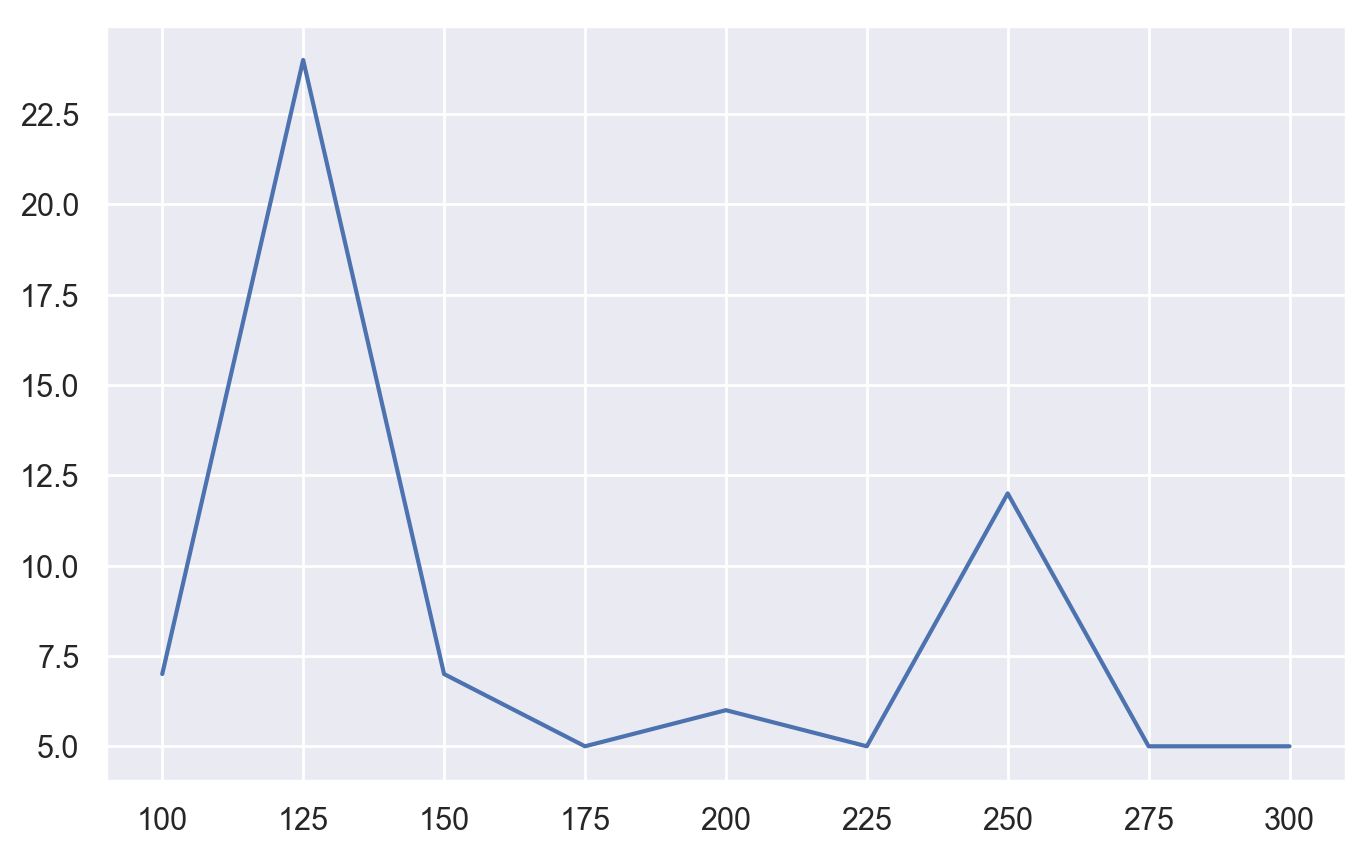

In [361]:
plot()
sns.lineplot(x=epsilons, y=iterations)